In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.read_csv('./data/October_missions_full.csv')
df['mission'] = df['type'] + '_' + df['target'].astype(str)

df = df[['user', 'mission', 'createdAtT', 'type', 'target', 'completed', 'performance']]
df['createdAtT'] = pd.to_datetime(df['createdAtT'], unit='ms').dt.date
df['user'] = df['user'].astype('category').cat.codes
df['mission'] = df['mission'].astype('category')
df['type'] = df['type'].astype('category')

df.sort_values(by=['createdAtT', 'user'], inplace=True, ignore_index=True)
df

,user,mission,createdAtT,type,target,completed,performance
0,0,episode_2,2024-10-01,episode,2,False,0.0
1,0,action_2,2024-10-01,action,2,False,0.0
2,0,episode_1,2024-10-01,episode,1,True,1.0
3,0,quiz_1,2024-10-01,quiz,1,True,1.0
4,0,quiz_4,2024-10-01,quiz,4,True,1.0
...,...,...,...,...,...,...,...
91353,7256,episode_5,2024-10-31,episode,5,False,0.0
91354,7256,activity_5,2024-10-31,activity,5,False,0.2
91355,7260,episode_5,2024-10-31,episode,5,False,0.0
91356,7260,mobility_1,2024-10-31,mobility,1,False,0.0


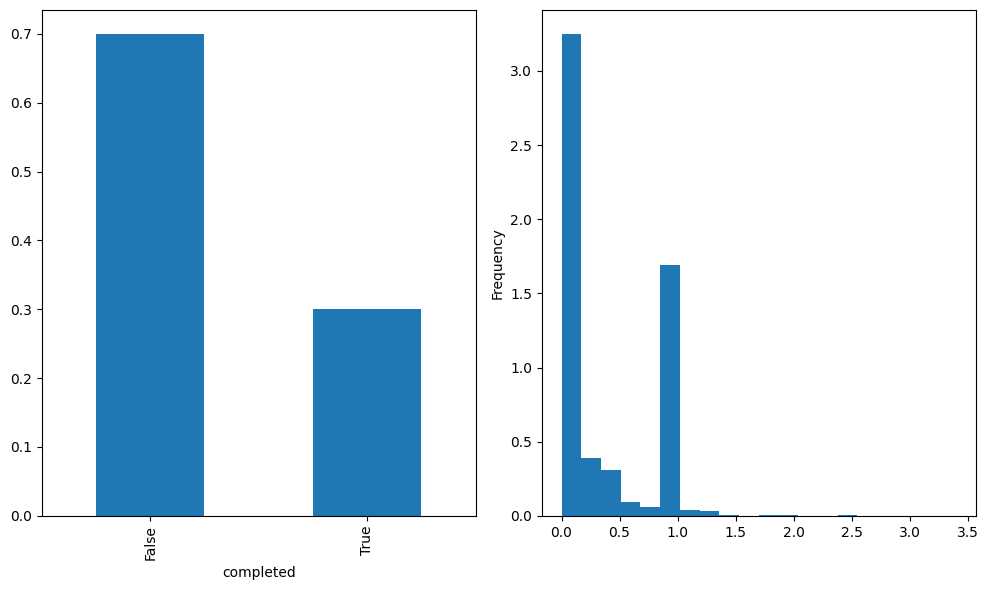

In [2]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
df['completed'].value_counts(normalize=True).plot(kind='bar')

plt.subplot(1, 2, 2)
df['performance'].plot.hist(bins=20, density=True)

plt.tight_layout()
plt.show()

<Axes: xlabel='mission'>

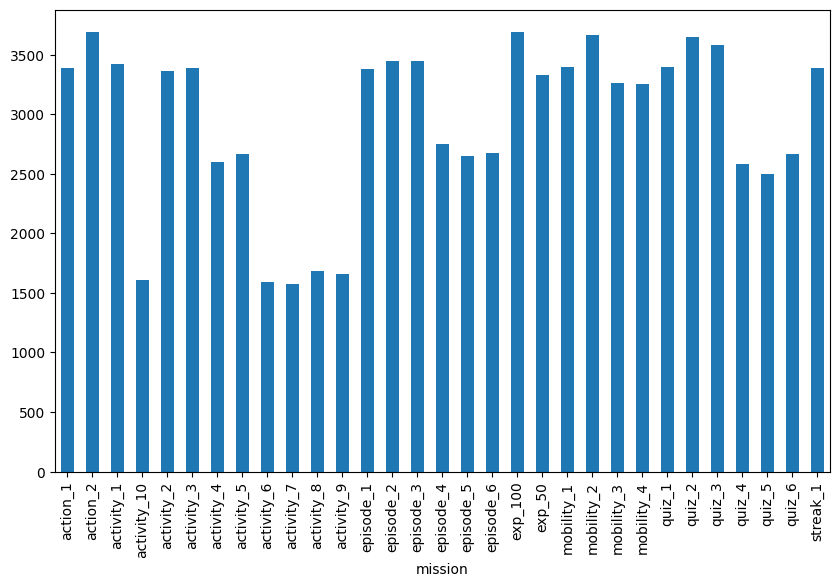

In [3]:
plt.figure(figsize=(10, 6))

df.groupby('mission', observed=True).size().plot(kind='bar')

In [4]:
def sequences(x: pd.Series, df: pd.DataFrame, day_window=3, missions_per_day=3):
    ts = x['createdAtT']
    ts_start = ts - pd.Timedelta(days=day_window)

    user_df: pd.DataFrame = df[(df['user'] == x['user']) & (df['createdAtT'] >= ts_start) & (df['createdAtT'] < ts)]
    user_df = user_df.sort_values(by='createdAtT', ascending=True)
    user_df = user_df.iloc[-missions_per_day * day_window:]
    return pd.Series({
        'id': str(x['user']) + '_' + str(ts),
        'mission': x['mission'],
        'ID': x['mission_id'],
        'history': user_df[['mission_id', 'ok']].astype(int).values
    })

def get_negatives(x: pd.Series):
    neg = missions - set(x)
    return [list(neg)] * len(x)

df['ok'] = np.isclose(df['performance'], 1.0, rtol=0.15)
df['mission_id'] = df['mission'].cat.codes
missions = set(df['mission_id'])

sequences_df: pd.DataFrame = df[df['ok']].progress_apply(sequences, axis=1, args=(df,))
sequences_df = sequences_df[sequences_df['history'].apply(len) == 9]
sequences_df['negatives'] = sequences_df.groupby('id')['ID'].transform(get_negatives)
sequences_df.to_pickle('./data/dataset.pkl')

  0%|          | 0/26896 [00:00<?, ?it/s]